Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.


Compiling model...
Building feed-forward neural network...
'build' took 0.163123 s



C:\Users\kozak\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+202=202. 
  warnings.warn("The balance properties of Sobol' points require "
C:\Users\kozak\anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
C:\Users\kozak\anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.911707 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [9.02e-02, 2.37e+01, 9.43e+02]    [8.98e-02, 2.37e+01, 9.43e+02]    []  
1000      [1.02e-01, 4.73e+01, 1.69e+02]    [1.00e-01, 4.73e+01, 1.69e+02]    []  
2000      [2.63e+00, 2.00e+01, 4.96e+01]    [2.63e+00, 2.00e+01, 4.96e+01]    []  
3000      [9.60e-01, 2.63e+00, 5.68e+00]    [9.56e-01, 2.63e+00, 5.68e+00]    []  
4000      [1.09e-01, 2.04e-01, 4.78e-01]    [1.01e-01, 2.04e-01, 4.78e-01]    []  
5000      [3.43e-02, 9.75e-03, 2.28e-02]    [3.06e-02, 9.75e-03, 2.28e-02]    []  
6000      [1.37e-02, 3.69e-04, 6.07e-03]    [1.17e-02, 3.69e-04, 6.07e-03]    []  
7000      [5.29e-03, 3.39e-05, 5.34e-03]    [4.27e-03, 3.39e-05, 5.34e-03]    []  
8000      [2.21e-03, 1.34e-05, 3.35e-03]    [1.67e-03, 1.34e-05, 3.35e-03]    []  
9000      [8.91e-04, 5.46e-05, 1.76e-03]    [6.44e-04, 5.46e-05, 1.76e-03]    []  
10000   

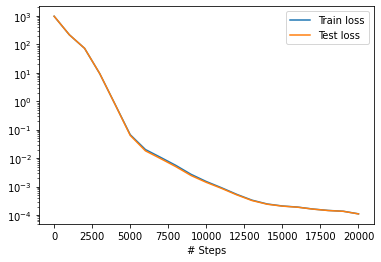

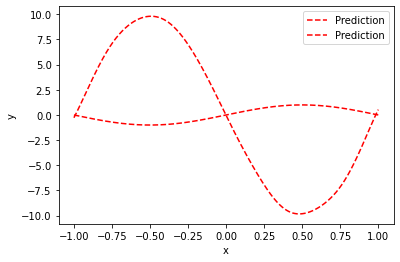

l2 relative error for u: 0.000448437
l2 relative error for q: 0.018951314


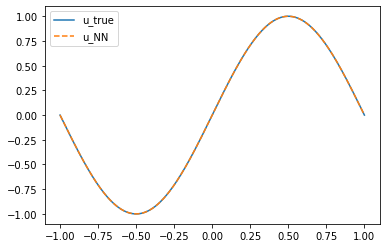

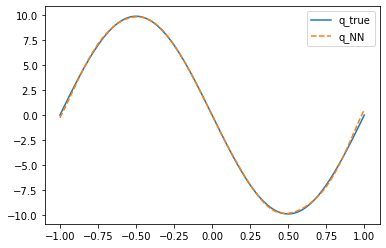

In [1]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np


def gen_traindata(num):
    # generate num equally-spaced points from -1 to 1
    xvals = np.linspace(-1, 1, num).reshape(num, 1)
    uvals = np.sin(np.pi * xvals)
    return xvals, uvals


def pde(x, y):
    u, q = y[:, 0:1], y[:, 1:2]
    du_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    return -du_xx + q


def sol(x):
    # solution is u(x) = sin(pi*x), q(x) = -pi^2 * sin(pi*x)
    return np.sin(np.pi * x)


geom = dde.geometry.Interval(-1, 1)

bc = dde.icbc.DirichletBC(geom, sol, lambda _, on_boundary: on_boundary, component=0)
ob_x, ob_u = gen_traindata(100)
observe_u = dde.icbc.PointSetBC(ob_x, ob_u, component=0)

data = dde.data.PDE(
    geom,
    pde,
    [bc, observe_u],
    num_domain=200,
    num_boundary=2,
    anchors=ob_x,
    num_test=1000,
)

net = dde.nn.PFNN([1, [20, 20], [20, 20], [20, 20], 2], "tanh", "Glorot uniform")

model = dde.Model(data, net)
model.compile("adam", lr=0.0001, loss_weights=[1, 100, 1000])
losshistory, train_state = model.train(iterations=20000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# view results
x = geom.uniform_points(500)
yhat = model.predict(x)
uhat, qhat = yhat[:, 0:1], yhat[:, 1:2]

utrue = np.sin(np.pi * x)
print("l2 relative error for u: " + str(dde.metrics.l2_relative_error(utrue, uhat)))
plt.figure()
plt.plot(x, utrue, "-", label="u_true")
plt.plot(x, uhat, "--", label="u_NN")
plt.legend()

qtrue = -np.pi ** 2 * np.sin(np.pi * x)
print("l2 relative error for q: " + str(dde.metrics.l2_relative_error(qtrue, qhat)))
plt.figure()
plt.plot(x, qtrue, "-", label="q_true")
plt.plot(x, qhat, "--", label="q_NN")
plt.legend()

plt.show()